Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [1]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')

## Folder dir for saving and loading files

In [4]:
 model_name = 'psm_no_off_minert'
# model_name ='test'
# model_name = 'mtm_3links'
#model_name = 'mtm'


model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [8]:
_pi = sympy.pi

dh = []
springs = []

if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.067
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7+_pi,   True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]

    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.067
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    #springs = [tau_s]
    print("MTM")
    
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    springs = [q1]
    
elif (model_name == 'test_psm'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    x = [None]*10
    x[0] = (0,   -1, [1],        0,              0,     0,                       0,      False,  False, False) # Base
    x[1] = (1,   0,  [2],        0,     sympy.pi/2,     0,           q1+sympy.pi/2,       True,  False,  True) # Yaw
    x[2] = (2,   1,  [3, 4],        0, -sympy.pi/2,     0,              sympy.pi/2,       False, False, False) # -- Intermediate
    x[3] = (3,   2,  [5, 6],  -0.0296,           0,     0,    q2-beta - sympy.pi/2,        True,  False, True) # Pitch Back
    x[4] = (4,   2,  [] ,     0.0664 ,           0,     0,    q2-beta - sympy.pi/2,        True,  False, True) # Pitch Front                                    )
    x[5] = (5,   2,  [7],     -0.0296,           0,     0,   q2-beta2 - sympy.pi/2,        False,  False, False)    # Intermediate
    x[6] = (6,   3,  [8],       0.150,           0,     0,    -q2+beta+sympy.pi/2,      True,  False,  True)    # Pitch Bottom
    x[7] = (7,   5,  [],       0.1842,           0,     0,    -q2+beta2+sympy.pi/2,     True,  False,  True)    # Pitch Top
    x[8] = (8,   6,  [9],       0.516,           0,     0,                      q2,     True,  False,  True)    # Pitch End
    x[9] = (9,   8,  [10],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,     True,  False, True)    # Main Insertion
    dh = x
                              
elif (model_name == 'test_psm_long2'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*17
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4, 5],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [6, 10], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [12],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   3, [11],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[11] = (11,  10,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    
    x[12] = (12,   9, [13],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[13] = (13,  12, [14],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[14] = (14,  13, [15,16],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    x[15] = (15,  14, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    x[16] = (16,  14, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
    
elif (model_name == 'psm_no_off_minert'):
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*12
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [4, 7], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back                                  )
    x[4]  = ( 4,   3,  [5],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[5]  = ( 5,   4,  [6],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[6]  = ( 6,   5, [9],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[7]  = ( 7,   3, [8],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[8]  = ( 8,  7,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    x[9] = (9,   6, [10],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[10] = (10,  9, [11],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[11] = (11,  10, [12,13],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    #x[12] = (12,  11, [],            0,           0,     0,                     -q7, False, False,  True) # Gripper1
    #x[13] = (13,  11, [],            0,           0,     0,                      q7, False,  True,  True) # Gripper2
    dh = x
       
else:
    raise Exception("No robot name matches " + name)

    
robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous'])

## Create kinematics chain

In [9]:
geom = Geometry(robot_def)

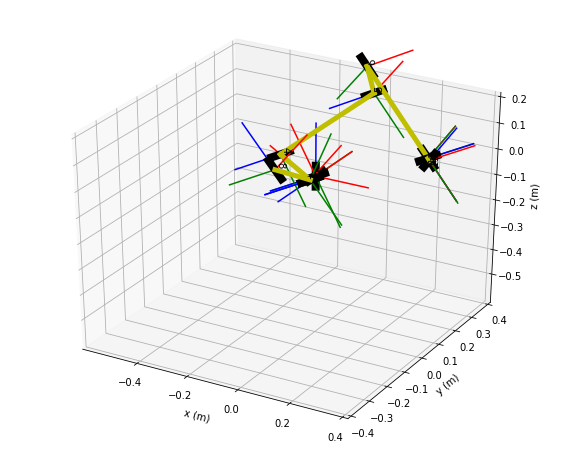

In [10]:
angle = [0.5, -0.2, 0.2, 0, 0, 0, 0]
#angle = [-0.6, 0.5, 0.2, 0.0]
geom.draw_geom(angle)

## Create dynamics

In [11]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/11
Calculating the link kinetic energy of 3/11
Calculating the link kinetic energy of 4/11
Calculating the link kinetic energy of 5/11
Calculating the link kinetic energy of 6/11
Calculating the link kinetic energy of 8/11
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
Adding frictions, motor rotor inertia and springs...
Calculating gregressor...
('input_vars', (q1, q2, q3, q4, q5, q6, dq1, dq2, dq3, dq4, dq5, dq6, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6))
Calculating M, C and G...
Calculating base parameter...
base parameter number: 31
Creating H_b function...
Finished creating robot dynamics
CPU times: user 20.4 s, sys: 544 ms, total: 20.9 s
Wall time: 19.4 s


In [12]:
sympy.Matrix(dyn.base_param)
#dyn.base_param_num

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [13]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Yes DONE', len(robot_model.base_param))

('Yes DONE', 31)


---
# 3 - Excitation trajectory optimization

In [2]:
 model_name = 'psm_no_off_minert'
# model_name ='test'
# model_name = 'mtm_3links'
#model_name = 'mtm'

Load Data

In [3]:
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [4]:
trajectory_name = 'two'
robot_model.std_param

In [5]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.14
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'mtm':
#     joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q4, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q5, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q6, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q7, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q8, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
#     joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q4, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q5, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
#                          (q8, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]

    joint_constraints = [(q1, deg2rad(-60), deg2rad(32), -1*np.pi, 1*np.pi),
                         (q2, deg2rad(-10), deg2rad(60), -1*np.pi, 1*np.pi),
                         (q3, deg2rad(-32), deg2rad(33), -2*np.pi, 2*np.pi),
                         (q4, deg2rad(-90), deg2rad(195), -2*np.pi, 2*np.pi),
                         (q5, deg2rad(-87), deg2rad(180), -2*np.pi, 2*np.pi),
                         (q6, deg2rad(-40), deg2rad(38), -2*np.pi, 2*np.pi),
                         (q7, deg2rad(-460), deg2rad(450), -4*np.pi, 4*np.pi),
                         (q8, deg2rad(-7), deg2rad(37), -1*np.pi, 1*np.pi)]

#     cartesian_constraints = [(3,'max',1,0.4,1),
#                              (3,'min',-1,-1,-1)]
elif model_name == 'mtm_3links':
    joint_constraints = [(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                         (q3, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)]
    
    cartesian_constraints = [(1,'max',1,0.4,1),
                             (1,'min',-1,-1,-1),
                             (2,'max',1,0.4,1),
                             (2,'min',-1,-1,-1)]
    
    # MTM STUFF
#jnt_cnst = [(q1, -0.698132, 1.13446, -2, 2),(q2, -0.261799, 0.872665, -2, 2), (q3,-0.172665, 0.610865, -2, 2)]
#jnt_cnst = [(q1, -1.5, 1.5, -2, 2),(q2, -1.5, 1.5, -2, 2), (q3,-1.5, 1.5, -2, 2)]    

#crt_cnst = [(4, 'max', -0.283, 0.279, -0.25137), (4, 'min', -0.5, -0.321, -0.39137)]
#crt_cnst = [(3, 'max', -0.300, 0.3, -0.26137), (3, 'min', -0.5, -0.45, -0.53137)]

elif model_name == 'psm':
    pass
elif model_name == 'psm_no_off_minert':
    x = 2
    joint_constraints = [(q1, -1.4, 1.4, -2, 2),
                         (q2, -0.7, 0.7, -2, 2),
                         (q3,0.065,0.23,-0.4,0.4),
                         (q4,-1.5,1.5,-x,x),
                         (q5,-1.5,1.5,-x,x), 
                         (q6,-1.5,1.5,-x,x)]
  # (q7,0.05, 0.75,-x,x) 
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 6
cartesian constraint number: 0
constraint number: 24
frames_constrained: []
Condition number: 157.915987105
x: [ 5.16160498e-02 -1.72760113e-02  4.03375925e-02 -5.79760798e-02
  2.11758308e-01  7.52151847e-01  3.11765193e-01 -1.15925465e-02
  3.04811257e-02  8.01356609e-02 -1.89383509e-01  1.69068521e+00
 -2.44598779e-02  1.54812225e-02 -1.93273562e-02  9.51601158e-01
  1.10626149e-01  4.36809890e-01  2.40440382e-01 -7.11060339e-01
 -3.18289792e-02  8.81739607e-01  2.94189460e-02 -2.32396395e-02
 -1.28600195e-01  8.79405418e-01  1.46308853e-01  1.19368329e-03
  5.19310394e-02 -6.05856285e-02  2.87590680e-02 -7.14053699e-02
  1.23152475e-01 -1.95579019e-02  1.84701175e-02  5.40833315e-02
 -5.75669878e-02  1.45374341e-01  2.48041525e-01  8.63533360e-02
  2.98039995e-01  4.24407291e-01  2.31003633e-02  3.86610846e-01
  2.34687761e-02 -9.82714679e-02  3.90911992e-01 -1.63851829e-01
  1.71522637e-01  8.92706830e-02  6.03215314e-02  1.20735566e-01
  1.27517978e-01 

## Plot optimal excitation trajectory

In [6]:
traj_optimizer.calc_frame_traj()
#print(traj_optimizer.frame_traj[0])
#sympy.Matrix(robot_model.base_param)

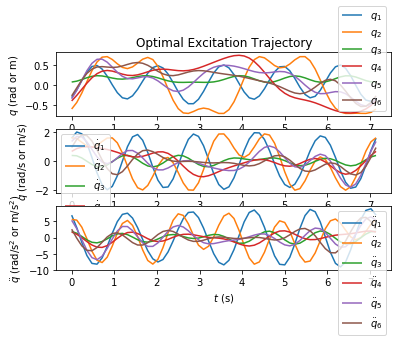

In [7]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj, traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [8]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x)

freq = 200
tf = 30
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)

# Save CSV for

In [9]:
dof_order_bf_x

(6,
 6,
 0.14,
 array([ 5.16160498e-02, -1.72760113e-02,  4.03375925e-02, -5.79760798e-02,
         2.11758308e-01,  7.52151847e-01,  3.11765193e-01, -1.15925465e-02,
         3.04811257e-02,  8.01356609e-02, -1.89383509e-01,  1.69068521e+00,
        -2.44598779e-02,  1.54812225e-02, -1.93273562e-02,  9.51601158e-01,
         1.10626149e-01,  4.36809890e-01,  2.40440382e-01, -7.11060339e-01,
        -3.18289792e-02,  8.81739607e-01,  2.94189460e-02, -2.32396395e-02,
        -1.28600195e-01,  8.79405418e-01,  1.46308853e-01,  1.19368329e-03,
         5.19310394e-02, -6.05856285e-02,  2.87590680e-02, -7.14053699e-02,
         1.23152475e-01, -1.95579019e-02,  1.84701175e-02,  5.40833315e-02,
        -5.75669878e-02,  1.45374341e-01,  2.48041525e-01,  8.63533360e-02,
         2.98039995e-01,  4.24407291e-01,  2.31003633e-02,  3.86610846e-01,
         2.34687761e-02, -9.82714679e-02,  3.90911992e-01, -1.63851829e-01,
         1.71522637e-01,  8.92706830e-02,  6.03215314e-02,  1.20735566e-0

In [10]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

ImportError: No module named tabulate

---
# Data processing

In [35]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [39]:
# Names as Arguments
# model_name = 'test_psm_long'
model_name = 'mtm_3links'

trajectory_name = 'one'
# trajectory_name = 'two'

In [40]:


# Folders Standard
model_folder = 'data/' + model_name + '/model/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
results_folder = 'data/' + model_name +'/measured_trajectory/'
results_data_file = results_folder + trajectory_name + '_results.csv'

# Load Results
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(results_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

# Load Robot Model
robot_model = load_data(model_folder,model_name)

IOError: File data/mtm_3links/measured_trajectory/one_results.csv does not exist

## Calculate filter cut-off frequency

In [5]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (5989, 7)
0
1
2
3
4
5
6
plot shape: 470


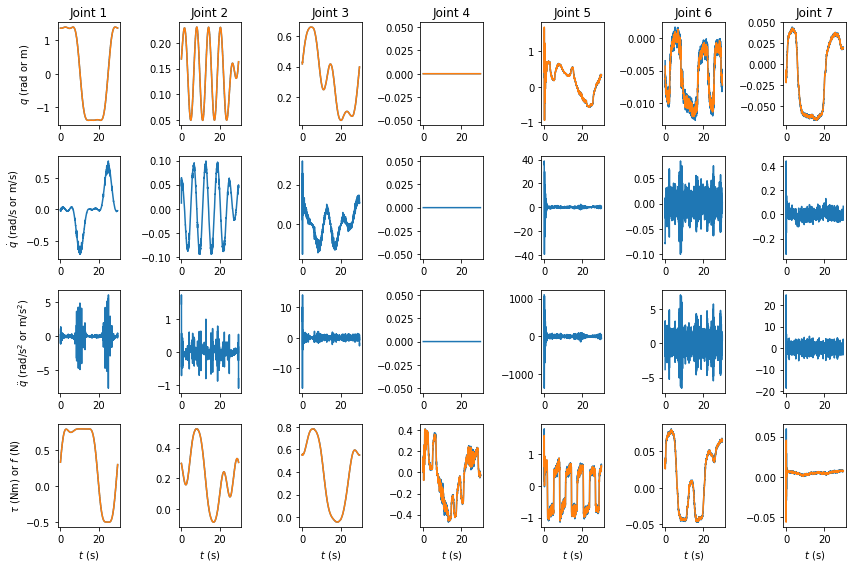

In [20]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [24]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [29]:
print(W_b.shape, tau_s.shape)
print(np.linalg.cond(W_b))

((41853, 30), (41853,))
1.4514895033065553e+25


In [30]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/radian/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [31]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

⎡                    1.0⋅m₉                        -0.0392024581323385 ⎤
⎢                                                                      ⎥
⎢             0.6025⋅l11z + 1.0⋅l9z                 1.31463802873679   ⎥
⎢                                                                      ⎥
⎢                    1.0⋅m₁₁                        0.100389480375818  ⎥
⎢                                                                      ⎥
⎢             0.6025⋅l11x + 1.0⋅l9y                0.0095179063328779  ⎥
⎢                                                                      ⎥
⎢                   1.0⋅Ia₁₃                      -0.000335510650252889⎥
⎢                                                                      ⎥
⎢              1.0⋅Fv₁₅ + 1.0⋅Fv₁₆                 0.0451563367550902  ⎥
⎢                                                                      ⎥
⎢                   1.0⋅Fv₁₂                        -1693851135.46323  ⎥
⎢                                                  

## Compare measured torque and predicted torque

### Generate predicted torque

In [32]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]
    

### Evaluate regression

In [33]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0015394491969555502


LinAlgError: Singular matrix

### Plot measured torque and predicted torque

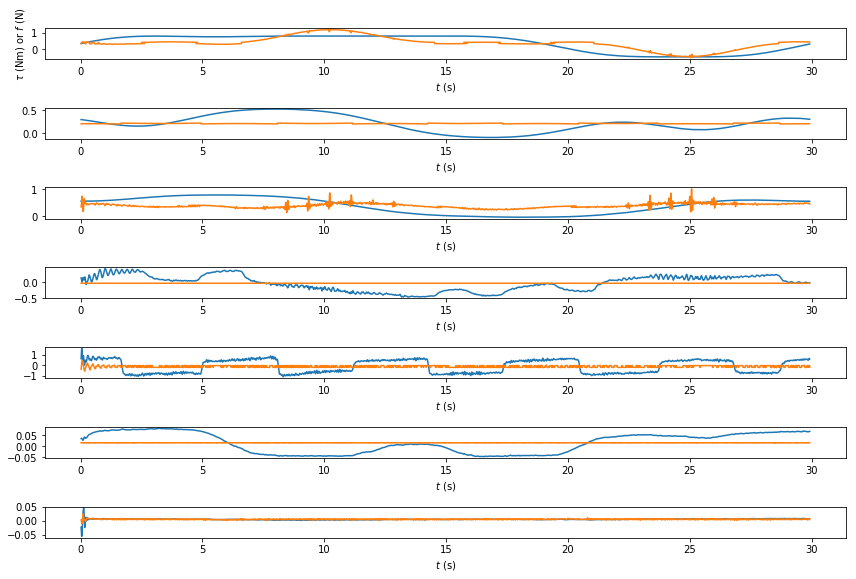

In [34]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [47]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [48]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [49]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [50]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [51]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]

In [52]:
sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 40)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param40
Solving problem...
[ 5.05454123e-06  0.00000000e+00  0.00000000e+00  5.05454123e-06
  0.00000000e+00  1.02027256e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.02186516e+00  1.15895153e-03  6.21843090e-03
  6.26571254e-03  1.67757862e-02  1.27923043e-03  1.00176550e-03
  1.49382983e-01  5.05271569e-04  1.25566069e-01  3.99822814e-01
  1.34128264e-03 -7.32957458e-03  2.99833900e+00  6.44713185e-03
  5.86822382e-03  9.35162445e-03  3.26097591e-02 -2.06679605e-02
 -1.12189288e-03  1.36212674e-01  1.26942012e-03  1.24636922e-01
  4.52904789e-01  7.95054568e-02  2.86758023e-03  1.69235798e+00
  1.27772610e-02  2.59175565e-03 -2.03874530e-03  7.51071930e-04]


In [53]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [54]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

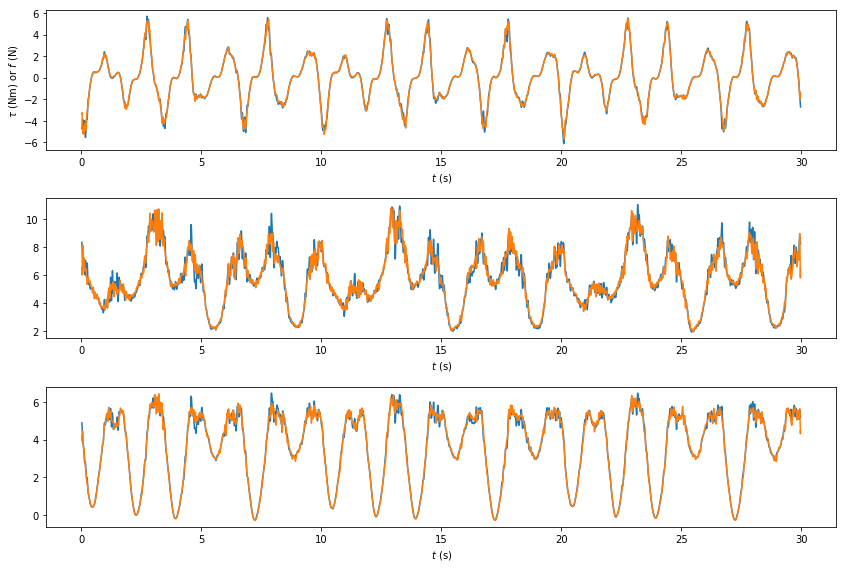

In [55]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [56]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx  5.05454123293039e-6 ⎤
⎢                          ⎥
⎢L1xy          0.0         ⎥
⎢                          ⎥
⎢L1xz          0.0         ⎥
⎢                          ⎥
⎢L1yy  5.05454123293039e-6 ⎥
⎢                          ⎥
⎢L1yz          0.0         ⎥
⎢                          ⎥
⎢L1zz  1.02027256158601e-5 ⎥
⎢                          ⎥
⎢l1x           0.0         ⎥
⎢                          ⎥
⎢l1y           0.0         ⎥
⎢                          ⎥
⎢l1z           0.0         ⎥
⎢                          ⎥
⎢ m₁     1.02186515608653  ⎥
⎢                          ⎥
⎢Fc₁   0.00115895152669689 ⎥
⎢                          ⎥
⎢Fv₁   0.00621843089597379 ⎥
⎢                          ⎥
⎢Fo₁   0.00626571253626371 ⎥
⎢                          ⎥
⎢L2xx   0.0167757861885383 ⎥
⎢                          ⎥
⎢L2xy   0.0012792304311218 ⎥
⎢                          ⎥
⎢L2xz  0.00100176549783867 ⎥
⎢                          ⎥
⎢L2yy   0.149382982571649  ⎥
⎢                          ⎥
⎢L2yz  0.00050

In [57]:
from identification import barycentric2standard_params

In [58]:
sdp_opt_std.x_result

array([ 5.05454123e-06,  0.00000000e+00,  0.00000000e+00,  5.05454123e-06,
        0.00000000e+00,  1.02027256e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.02186516e+00,  1.15895153e-03,  6.21843090e-03,
        6.26571254e-03,  1.67757862e-02,  1.27923043e-03,  1.00176550e-03,
        1.49382983e-01,  5.05271569e-04,  1.25566069e-01,  3.99822814e-01,
        1.34128264e-03, -7.32957458e-03,  2.99833900e+00,  6.44713185e-03,
        5.86822382e-03,  9.35162445e-03,  3.26097591e-02, -2.06679605e-02,
       -1.12189288e-03,  1.36212674e-01,  1.26942012e-03,  1.24636922e-01,
        4.52904789e-01,  7.95054568e-02,  2.86758023e-03,  1.69235798e+00,
        1.27772610e-02,  2.59175565e-03, -2.03874530e-03,  7.51071930e-04])

In [59]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [60]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx   5.05454123293039e-6 ⎤
⎢                           ⎥
⎢I1xy            0          ⎥
⎢                           ⎥
⎢I1xz            0          ⎥
⎢                           ⎥
⎢I1yy   5.05454123293039e-6 ⎥
⎢                           ⎥
⎢I1yz            0          ⎥
⎢                           ⎥
⎢I1zz   1.02027256158601e-5 ⎥
⎢                           ⎥
⎢r1x            0.0         ⎥
⎢                           ⎥
⎢r1y            0.0         ⎥
⎢                           ⎥
⎢r1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     1.02186515608653   ⎥
⎢                           ⎥
⎢Fc₁    0.00115895152669689 ⎥
⎢                           ⎥
⎢Fv₁    0.00621843089597379 ⎥
⎢                           ⎥
⎢Fo₁    0.00626571253626371 ⎥
⎢                           ⎥
⎢I2xx   0.0167572687017968  ⎥
⎢                           ⎥
⎢I2xy   0.0014580879251093  ⎥
⎢                           ⎥
⎢I2xz   2.43806391970725e-5 ⎥
⎢                           ⎥
⎢I2yy   0.0960494516531994  ⎥
⎢         